# ETL_EDA
This file records the process of acquiring raw data, traforming them, and loading them into a MongoDB. The data are store (almost) in their raw form.

## 1. Raw Data from NY Times 
The [dataset](https://github.com/nytimes/covid-19-data) is a continuously updated (daily) txt file in csv format. It contains the covid-19 cases and deaths in US states and counties (historical data that has the final counts at the end of each day)

In [42]:
import requests
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib
from datetime import datetime, timedelta, time

from matplotlib import pyplot as plt
import pymongo


urls = {'counties': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
        'states': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
        'us': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'}

filters = {'us': ['date'],
           'states': ['date', 'state'],
           'counties': ['date', 'state', 'county']}

## 2. Raw Data to Documents/Dicts
Using pandas, it is simple to parse a in-memory string. The first few lines of description need to be skipped. Datetime conversion is made and blank lines are dropped. Now the data can be easily converted to a list of dicts which is what we want for the MongoDB.

In [11]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [7]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [9]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [53]:
states = list(df['state'].unique())

## 3. Upsert MongoDB
If we fetch the data frequently, there are lots of duplicate data entry between each run. The de-duplication happens at insertion. The MongoDB API to use is `collection.replace_one(filter=..., replacement=..., upsert=True)`. The statement matches a document in MongoDB with `filter`, replaces it with `replacement` if the document exists or inserts `replacement` into the database if `filter` matches nothing. 

In [2]:
# from data_acquire import data_fetch
def data_fetch(geo):
    client = pymongo.MongoClient()
    
    # get url
    url = urls[geo]
    
    # raw data from nyt
    req = requests.get(url, timeout=1)
    req.raise_for_status()
    text = req.text

    # raw data to df
    df = pd.read_csv(StringIO(text), delimiter=',')
    df.columns = df.columns.str.strip()             # remove space in columns name
    df['date'] = pd.to_datetime(df['date'])
    df.dropna(inplace=True)  
    df.head()

    # upsert mangodb
    db = client.get_database(geo)   
    collection = db.get_collection(geo) 

    update_count = 0
    for record in df.to_dict('records'):
        result = collection.replace_one(
            filter={_:record[_] for _ in filters[geo]},    # locate the document if exists
            replacement=record,                         # latest document
            upsert=True)                                # update if exists, insert if not
        if result.matched_count > 0:
            update_count += 1
    print(f'{geo}:', 
          f'rows={df.shape[0]}, update={update_count}, '
          f'insert={df.shape[0]-update_count}')

In [4]:
# %%time
# for geo in list(urls.keys()):
#     data_fetch(geo)
data_fetch('us')

us: rows=689, update=0, insert=689


In [2]:
# # db = client.get_database(geo)   
# # collection = db.get_collection(geo) 

# update_count = 0
# for record in df.to_dict('us'):
#     print(record)
#     result = collection.replace_one(
#         filter={_:record[_] for _ in filters[geo]},    # locate the document if exists
#         replacement=record,                         # latest document
#         upsert=True)                                # update if exists, insert if not
#     if result.matched_count > 0:
#         update_count += 1
# print(f"rows={df.shape[0]}, update={update_count}, "
#       f"insert={df.shape[0]-update_count}")

## Use the smallest datset -- 'us' for EDA.
### 1. Accumulated cases

In [45]:
client.get_database("us")

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'us')

In [7]:
client = pymongo.MongoClient()
db = client.get_database("us") # to-do: combine the three database into the same one...
collection = db.get_collection("us")
data = list(collection.find())
df = pd.DataFrame.from_records(data)    
df.drop('_id', axis=1, inplace=True)
df

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
684,2021-12-05,49044822,786964
685,2021-12-06,49242271,788315
686,2021-12-07,49356263,790082
687,2021-12-08,49505304,791933


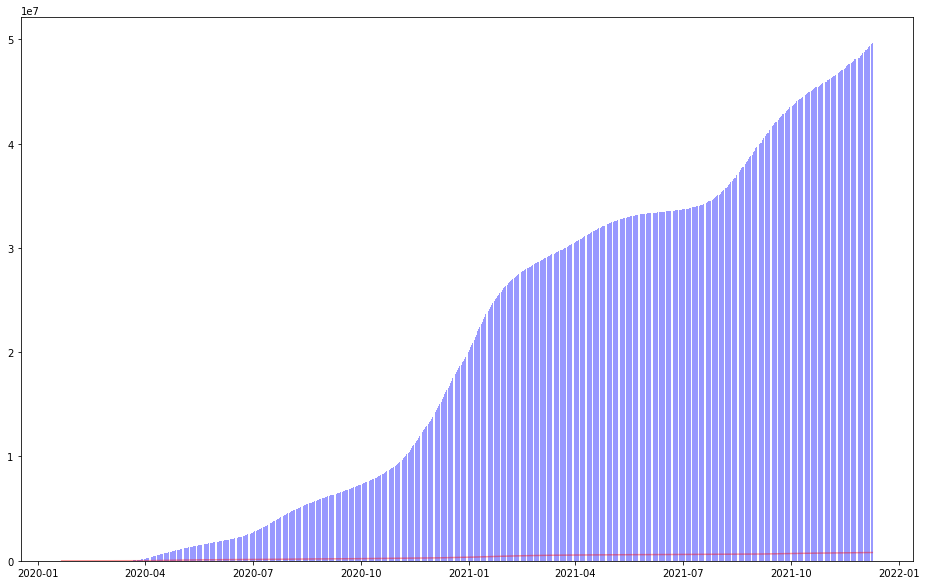

In [16]:
plt.figure(figsize=(16, 10))

plt.bar(df.date.values, df.cases.values, color = 'blue' , label='Cases over time', alpha=0.4)
plt.plot(df.date.values, df.deaths.values, color = 'red', label='Deaths over time', alpha=0.4)


plt.show()

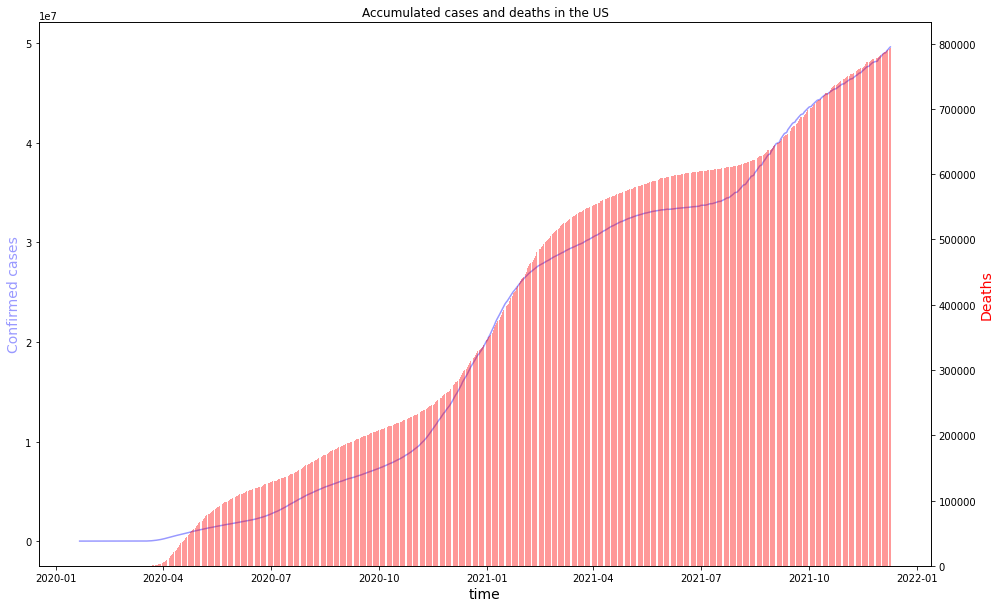

In [20]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(16, 10))

# make a plot
ax.plot(df.date.values, df.cases.values, color = 'blue' , label='Cases over time', alpha=0.4)

# set x-axis label
ax.set_xlabel("time",fontsize=14)
# set y-axis label
ax.set_ylabel("Confirmed cases", color="blue",fontsize=14, alpha=0.4)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.bar(df.date.values, df.deaths.values, color = 'red', label='Deaths over time', alpha=0.4)
ax2.set_ylabel("Deaths",color="red",fontsize=14)

plt.title('Accumulated cases and deaths in the US')
plt.show()
# # save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,

### 2. Daily cases and deaths
adjusted based on the code shown here: https://github.com/therealcyberlord/coronavirus_visualization_and_prediction/blob/master/coronavirus-covid-19-visualization-prediction.ipynb

In [21]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

In [23]:
us_daily_case = daily_increase(df.cases)
us_wavg_case = moving_average(us_daily_case, 7)



us_daily_deatlh = daily_increase(df.deaths)
us_wavg_death = moving_average(us_daily_deatlh, 7)

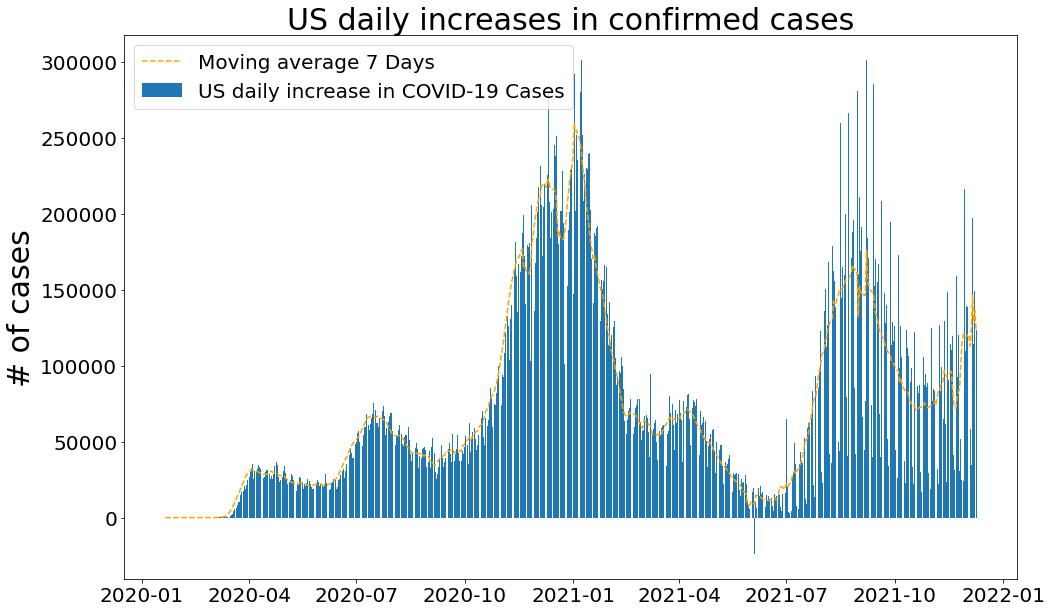

In [24]:
plt.figure(figsize=(16, 10))
plt.bar(df.date.values, us_daily_case)
plt.plot(df.date.values, us_wavg_case, color='orange', linestyle='dashed')
plt.title('US daily increases in confirmed cases', size=30)

plt.ylabel('# of cases', size=30)
plt.legend(['Moving average 7 Days', 'US daily increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

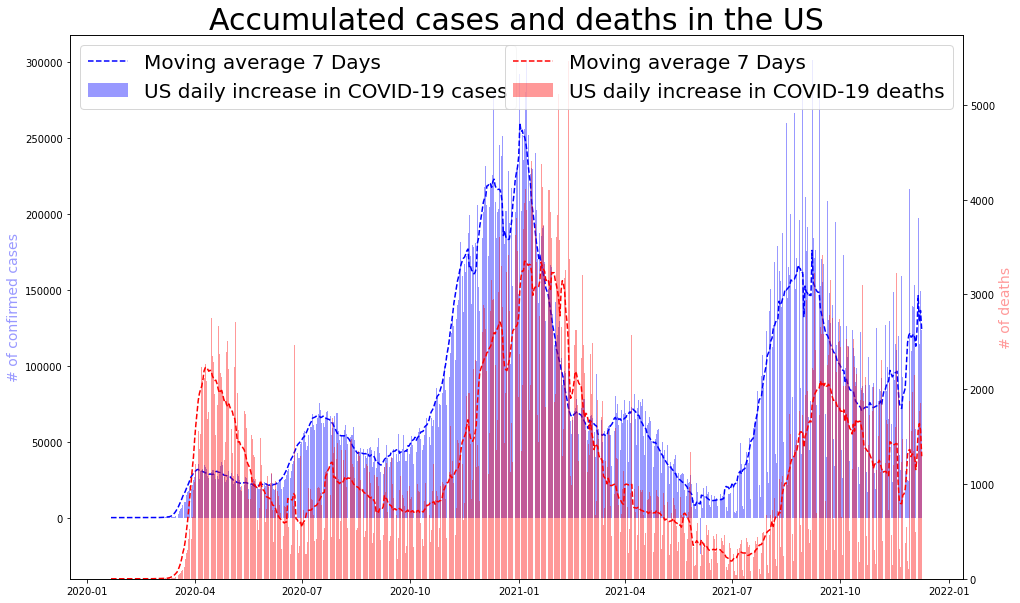

In [36]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(16, 10))

ax.bar(df.date.values, us_daily_case, color='blue', alpha=0.4)
ax.plot(df.date.values, us_wavg_case, color='blue', linestyle='dashed')

ax.set_ylabel('# of confirmed cases', color='blue', alpha=0.4, size=14)
ax.legend(['Moving average 7 Days', 'US daily increase in COVID-19 cases'], prop={'size': 20}, loc=2)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.bar(df.date.values, us_daily_deatlh, color = 'red', label='Deaths over time', alpha=0.4)
ax2.plot(df.date.values, us_wavg_death, color='red', linestyle='dashed')

ax2.set_ylabel("# of deaths", color = 'red', alpha=0.4, fontsize=14)
ax2.legend(['Moving average 7 Days', 'US daily increase in COVID-19 deaths'], prop={'size': 20}, loc=1)


plt.title('Accumulated cases and deaths in the US', size=30)
plt.show()

## Use the state datset -- 'states' for EDA
### Use the latest data (most updated)

In [9]:
data_fetch('states')

states: rows=35678, update=0, insert=35678


In [10]:
client = pymongo.MongoClient()
db = client.get_database("states")
collection = db.get_collection("states")
data = list(collection.find())
df_s = pd.DataFrame.from_records(data)    
df_s.drop('_id', axis=1, inplace=True)
df_s

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
35673,2021-12-09,Virginia,51,991221,14868
35674,2021-12-09,Washington,53,791832,9584
35675,2021-12-09,West Virginia,54,304355,5055
35676,2021-12-09,Wisconsin,55,1017528,10330


In [11]:
df_today = df_s[df_s.date==max(df_s.date)]
df_today.head()

,date,state,fips,cases,deaths
35622,2021-12-09,Alabama,1,850645,16203
35623,2021-12-09,Alaska,2,151979,862
35624,2021-12-09,American Samoa,60,1,0
35625,2021-12-09,Arizona,4,1305260,22854
35626,2021-12-09,Arkansas,5,536368,8810


In [47]:
max(df_s.date) - timedelta(days=1)

Timestamp('2021-12-08 00:00:00')

'2021-12-08'

In [37]:
df_s.date

SyntaxError: unmatched ')' (211733512.py, line 1)

In [32]:
df_ = [df_s.date==max(df_s.date) - timedelta(days=1)]

Timestamp('2021-12-08 00:00:00')

In [63]:
yester = (max(df_s.date) - timedelta(days=1)).strftime('%Y-%m-%d')
df_yest = df_s[df_s.date==yester]
df_yest

,date,state,fips,cases,deaths
35566,2021-12-08,Alabama,1,850096,16203
35567,2021-12-08,Alaska,2,151979,862
35568,2021-12-08,American Samoa,60,1,0
35569,2021-12-08,Arizona,4,1301597,22779
35570,2021-12-08,Arkansas,5,535450,8796
35571,2021-12-08,California,6,5141243,75279
35572,2021-12-08,Colorado,8,854249,9694
35573,2021-12-08,Connecticut,9,433464,8946
35574,2021-12-08,Delaware,10,157751,2206
35575,2021-12-08,District of Columbia,11,68262,1197


In [105]:
df_24 = pd.DataFrame(df_today.cases.values - df_yest.cases.values, columns=['cases'], index=df_today.state.values)
df_24_death = pd.DataFrame(df_today.deaths.values - df_yest.deaths.values, columns=['deaths'], index=df_today.state.values)
df_24m = df_24.merge(df_24_death, on=df_24_death.index)


In [111]:
df_24m = df_24m.rename(columns={'key_0': 'state'})
df_24m.columns

Index(['state', 'cases', 'deaths'], dtype='object')

In [113]:
df_today_sorted = df_today.sort_values(by=['cases'], ascending=False)
df_24_sorted_c = df_24m.sort_values(by=['cases'], ascending=False)
df_24_sorted_d = df_24m.sort_values(by=['deaths'], ascending=False)

In [131]:
def prepare_pie(cases, states):
    '''
    cases: formatted as df_today_sorted.cases
    states: df_today_sorted.states

    '''
    visual_unique_states = [] 
    visual_confirmed_cases = []
    others = np.sum(cases[10:])

    for i in range(len(cases[:10])):
        visual_unique_states.append(list(states)[i])
        visual_confirmed_cases.append(np.array(cases)[i])
    
    visual_unique_states.append('Others')
    visual_confirmed_cases.append(others)

    return (visual_unique_states, visual_confirmed_cases)

In [118]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, shadow=True, colors=c, labels=y)  
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

In [138]:
a, b=prepare_pie(df_24_sorted_c.cases, df_24_sorted_c.state)

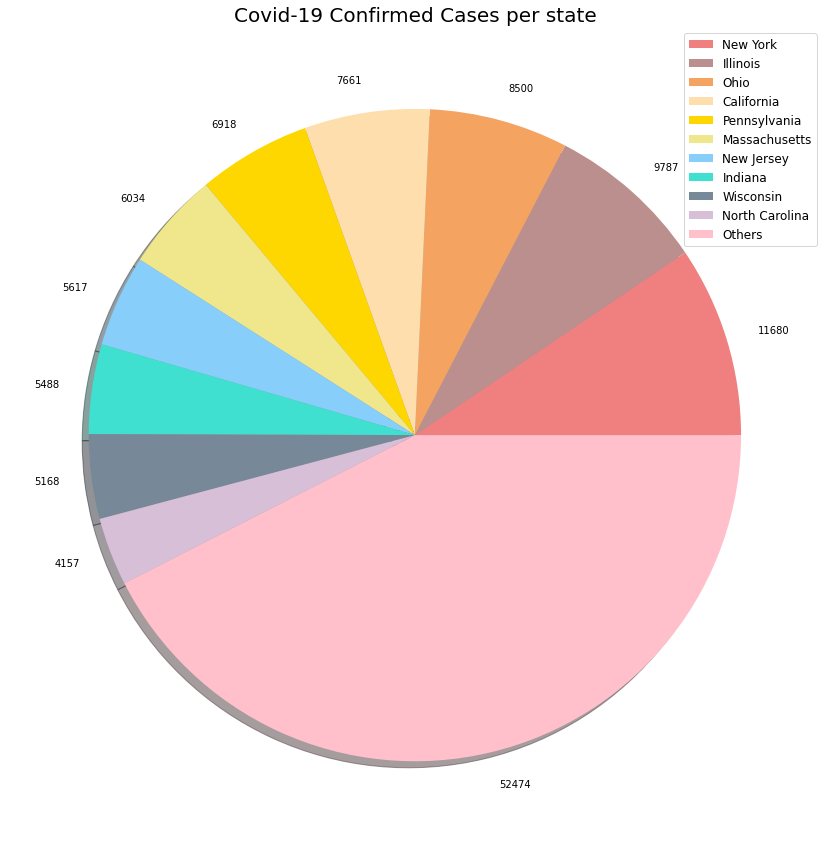

In [141]:
visual_unique_states, visual_confirmed_cases = prepare_pie(df_24_sorted_c.cases, df_24_sorted_c.state)
plot_pie_charts(visual_unique_states, visual_confirmed_cases, 'Covid-19 Confirmed Cases per state')


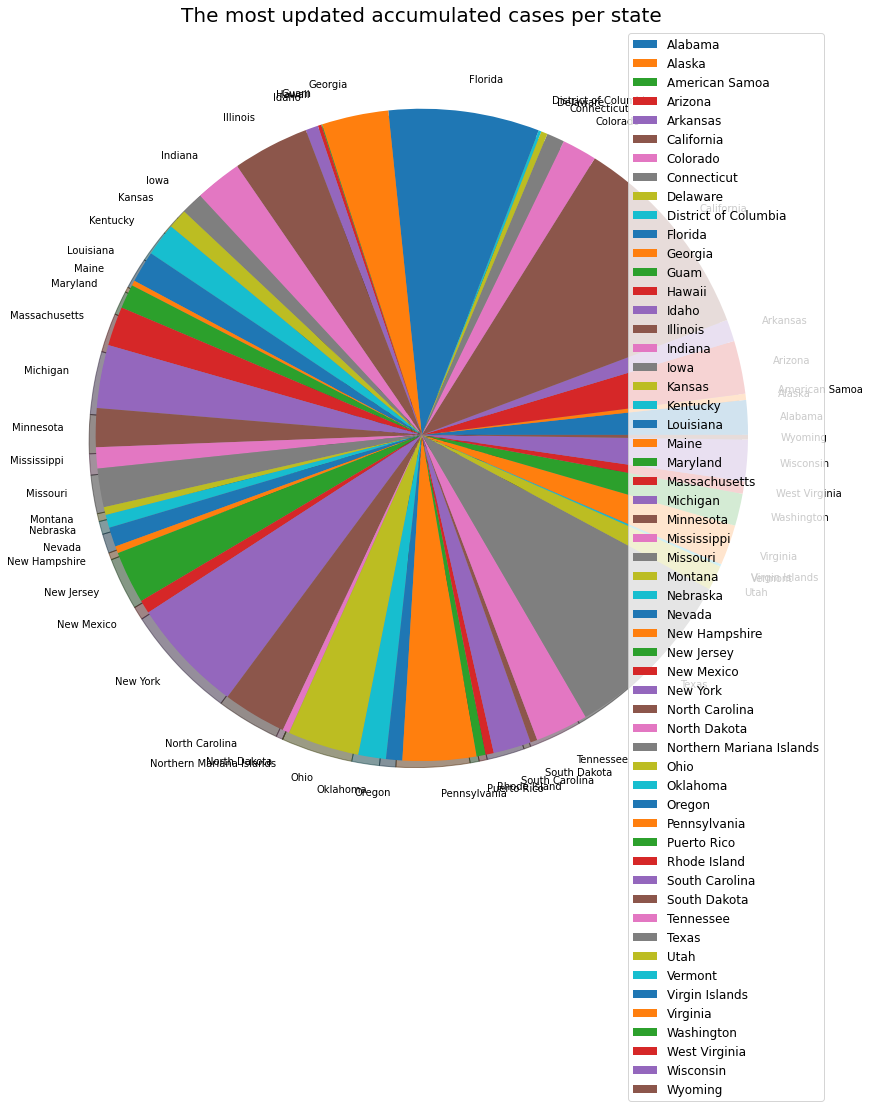

In [78]:

plt.figure(figsize=(20,15))
plt.title('The most updated accumulated cases per state', size=20)
plt.pie(df_today.cases,  shadow=True, labels=df_today.state)
plt.legend(df_today.state, loc='best', fontsize=12)


In [73]:
df_today.state.unique

<bound method Series.unique of 35622                     Alabama
35623                      Alaska
35624              American Samoa
35625                     Arizona
35626                    Arkansas
35627                  California
35628                    Colorado
35629                 Connecticut
35630                    Delaware
35631        District of Columbia
35632                     Florida
35633                     Georgia
35634                        Guam
35635                      Hawaii
35636                       Idaho
35637                    Illinois
35638                     Indiana
35639                        Iowa
35640                      Kansas
35641                    Kentucky
35642                   Louisiana
35643                       Maine
35644                    Maryland
35645               Massachusetts
35646                    Michigan
35647                   Minnesota
35648                 Mississippi
35649                    Missouri
35650            